# Notebook Setup (Import and Initialization)

In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from jupyterthemes import jtplot

In [2]:
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

# Image Setup

## Helper Functions

In [3]:
def squareCrop(x, squareDim):
    left = (x.size[0]-squareDim)/2
    upper = (x.size[1]-squareDim)/2
    right = (x.size[0] + squareDim)/2
    lower = (x.size[1] + squareDim)/2
    return x.crop(box = (left, upper, right, lower))

In [4]:
def resize(x, squareDim):
    width, height = x.size
    scale = squareDim/min(width, height)
    return x.resize((int(scale * width), int(scale * height)), resample = Image.LANCZOS)

In [5]:
def getImages(path, fileEnding, num):
    images = []
    for i in range(num):
        fp = Image.open(path + str(i) + fileEnding)
        fp.load() #to close file
        images.append(fp)

    minWidth = min(images, key = lambda x: x.size[0]).size[0]
    minHeight = min(images, key = lambda x: x.size[1]).size[1]
    squareDim = min(minWidth, minHeight)

    print(squareDim,"x",squareDim)

    cropfn = lambda x: x.crop(box = ((x.size[0]-squareDim)/2,(x.size[1]-squareDim)/2,squareDim,squareDim))
    for i in range(len(images)):
        images[i] = squareCrop(resize(images[i],squareDim), squareDim)#.convert('LA')
    return images

In [6]:
from PIL import Image
dogPath = "../Images/randDogSet/img"
buildingPath = "../Images/randBuildingSet/img"
fileEnding = ".jpg"
num = 230

dogImages = getImages(dogPath, fileEnding, num)
buildingImages = getImages(buildingPath, fileEnding, num)

126 x 126
131 x 131


## Images in the data set

In [7]:
def displayImages(images):
    i = 1
    plt.figure(figsize=(20,20))
    for im in images:
        ax = plt.subplot(23,10,i) #can change
        ax.imshow(np.asarray(im))
        ax.axis('off') 
        i += 1

## Dog Images

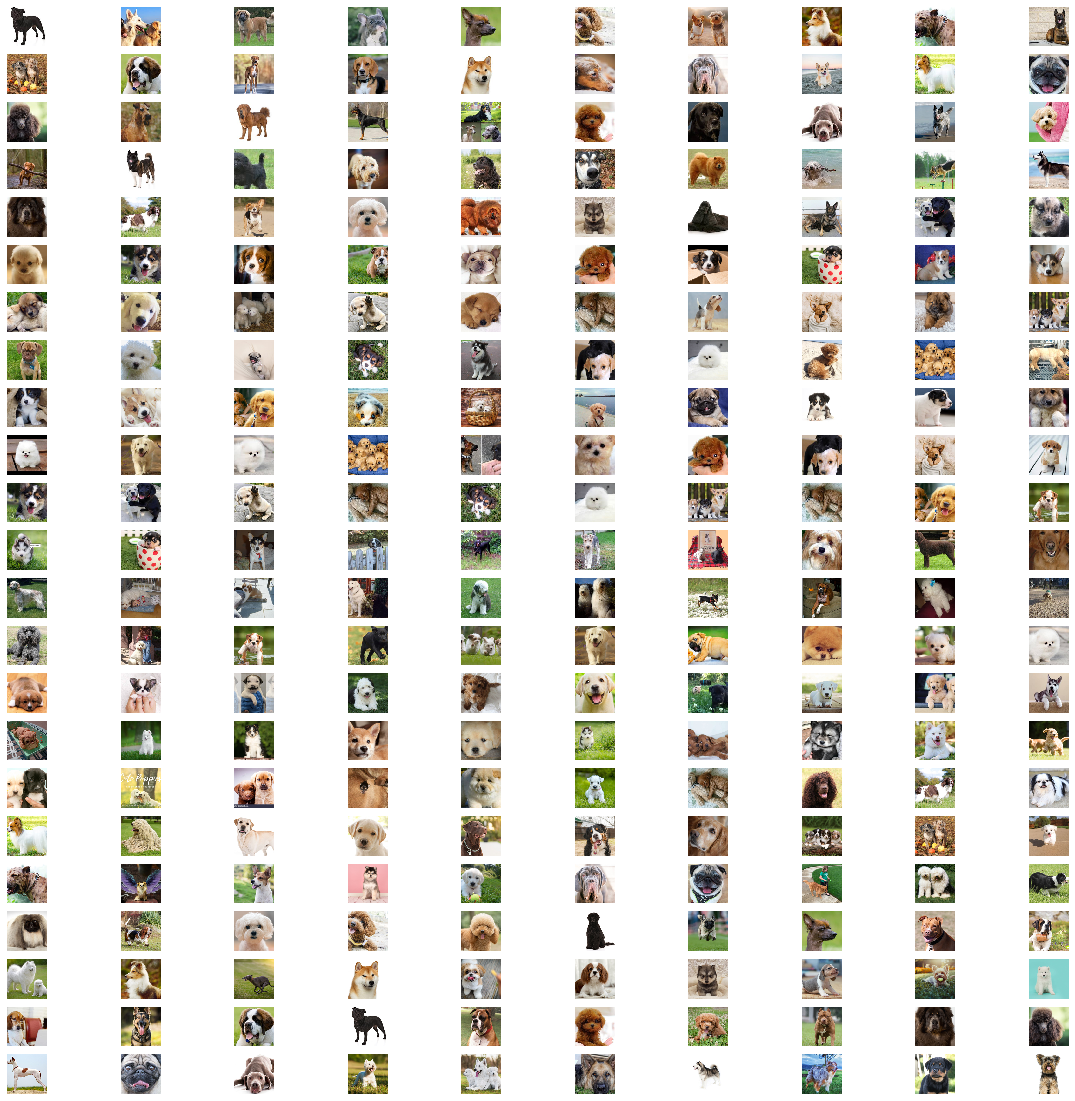

In [8]:
displayImages(dogImages)

## Building Images

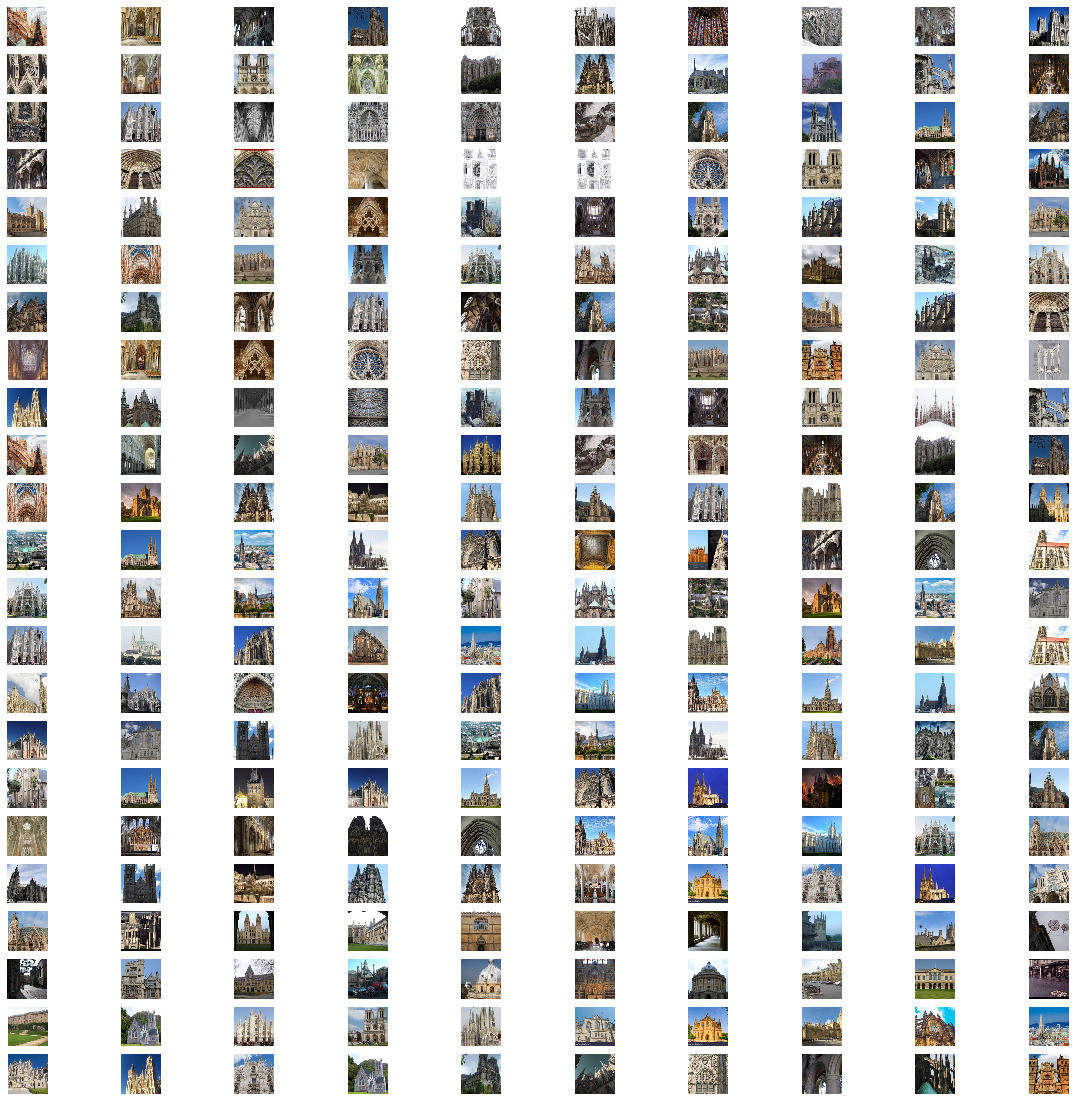

In [9]:
displayImages(buildingImages)

In [10]:
batch_t = []
i = 0
for img in dogImages + buildingImages:
    img_t = transform(img)
    batch_t.append(torch.unsqueeze(img_t, 0)) # batch_t is set of transformed image

# AlexNet Setup

In [11]:
alexnet = models.alexnet(pretrained = True)
alexnet.eval() # change alexnet model to eval mode
model = models.alexnet(pretrained=True)

In [12]:
out = []
for i in range(len(batch_t)):
    out.append(alexnet(batch_t[i]))
print(out[0].shape)
print(out[-1].shape)

torch.Size([1, 1000])
torch.Size([1, 1000])


In [38]:
i = 0
j = 0
weights = []
for child in model.children():
    print("child", i,":")
    if isinstance(child, nn.AdaptiveAvgPool2d):
        print("\t" + str(child))
    else:
        for param in child:
            print("\tLayer", j ,":", param)
            instance = isinstance(param, nn.ReLU) or isinstance(param, nn.MaxPool2d) or isinstance(param, nn.Dropout)
            if not instance:
                weights.append(param.weight)
            j += 1
    i += 1
# need to pick layer to read out the features from passing an image through the network 

child 0 :
	Layer 0 : Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
	Layer 1 : ReLU(inplace=True)
	Layer 2 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Layer 3 : Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
	Layer 4 : ReLU(inplace=True)
	Layer 5 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Layer 6 : Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 7 : ReLU(inplace=True)
	Layer 8 : Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 9 : ReLU(inplace=True)
	Layer 10 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 11 : ReLU(inplace=True)
	Layer 12 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
child 1 :
	AdaptiveAvgPool2d(output_size=(6, 6))
child 2 :
	Layer 13 : Dropout(p=0.5, inplace=False)
	Layer 14 : Linear(in_features=9216, out_features=4096, bias=True)
	Layer 15 : ReLU(i

# Truncation of neural net layers

In [39]:
l = list(model.children())
layerNum = 10 #layer starts from 0
delete = len(l[0]) - layerNum -1 #number of truncating layers from the model
print("Layer:", layerNum)
print("Deleted", delete)
nn_trunc = nn.Sequential(*l[0][:len(l[0])-delete])
nn_trunc.eval()

Layer: 10
Deleted 2


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Output of passing image to model

In [40]:
out = []
for i in range(2*num):
    out.append(nn_trunc(batch_t[i]))
print(out[0].shape)
print(out[-1].shape)

torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])


## Reshaping output to 2 dims

In [41]:
arr = []
for i in range(2 * num):
    arr.append(out[i].view(1, out[i].shape[0]*out[i].shape[1]*out[i].shape[2]*out[i].shape[3]))

## Convert to numpy matrix

In [42]:
import numpy as np
x = arr[0].detach().numpy()
for nparr in arr[1:]:
    x = np.vstack([x, nparr.detach().numpy()])

# Dimension Reductionality

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## PCA

In [44]:
print(x.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(x)
print(pca_result.shape)

(460, 43264)
(460, 50)


## TSNE

In [45]:
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)
print(tsne_pca_results.shape)

(460, 3)


# Plotting Results from Dimensional Reductionality

In [46]:
dogs = tsne_pca_results[:num]
buildings = tsne_pca_results[num:]

<IPython.core.display.Javascript object>


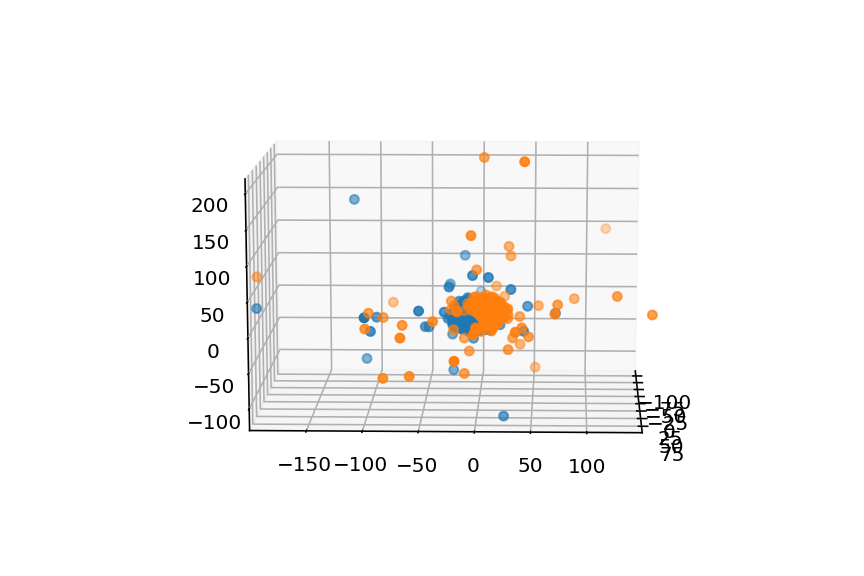

In [47]:
%matplotlib notebook
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = dogs[:,0],dogs[:,1],dogs[:,2]
ax.scatter(x,y,z)

x,y,z = buildings[:,0],buildings[:,1],buildings[:,2]
ax.scatter(x,y,z)

# Saving Arrays to file

In [48]:
np.savetxt('./output/dog_layer' + str(layerNum) + '.txt', dogs, fmt='%d')
np.savetxt('./output/building_layer' + str(layerNum) + '.txt', buildings, fmt='%d')

# Example: Loading array from file

In [54]:
layerToLoad = 6
dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')
print(a, a.shape)

[[  12.    9.  -11.]
 [ -21.  -11.    6.]
 [  -4.    2.   20.]
 [  39.  -19.  140.]
 [ -29.   -8.   34.]
 [   3.    7.   -4.]
 [ -26.    0.    0.]
 [ -20.    3.  -14.]
 [   8.   -9.  -19.]
 [  12.   19.   11.]
 [  21.    5.    6.]
 [   6.    8.  -15.]
 [   0.   21.    9.]
 [  -9.  -23. -146.]
 [ -10.    4.  -18.]
 [  -6.   12.   -7.]
 [  -1.    5.   -9.]
 [ -13.   -8.  -14.]
 [ -18.   14.   -1.]
 [  -3.    3.    8.]
 [  -4.   42.   96.]
 [  10.   12.   15.]
 [   5.   -2.  -16.]
 [   0.    0.  -24.]
 [  -1.   -5.   -9.]
 [   6.  -15.   23.]
 [  -6.   85.   14.]
 [   5.   23.    8.]
 [  12.   14.  -17.]
 [ -22.   -4.   -4.]
 [  -5.    0.    1.]
 [   3.   -3.  -20.]
 [ -12.   13.   -9.]
 [ -12.   14.    4.]
 [  -1.    0.   -3.]
 [   0.    3.   11.]
 [-129.  -22.   -3.]
 [  10.    8.  -20.]
 [ -17.    0.    6.]
 [ -18.   -3.  -18.]
 [  -3.  -53.   -1.]
 [   7.    1.  -12.]
 [  -2.   20.    5.]
 [  -7.   -5.  -42.]
 [   0.    0.  -14.]
 [  14.  -79.   70.]
 [   1.   23.  -17.]
 [ -25.   -6.

# Layer Comparison

In [65]:
def loadPlot(layerToLoad):
    dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
    buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')

    %matplotlib notebook
    fig= plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x,y,z = dogs[:,0],dogs[:,1],dogs[:,2]
    ax.scatter(x,y,z)

    x,y,z = buildings[:,0],buildings[:,1],buildings[:,2]
    ax.scatter(x,y,z)

<IPython.core.display.Javascript object>


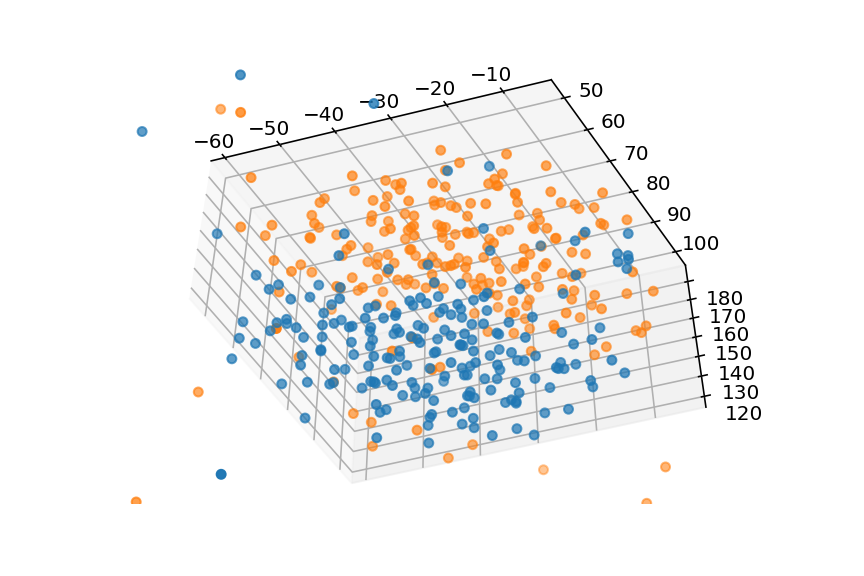

In [68]:
loadPlot(3)

<IPython.core.display.Javascript object>


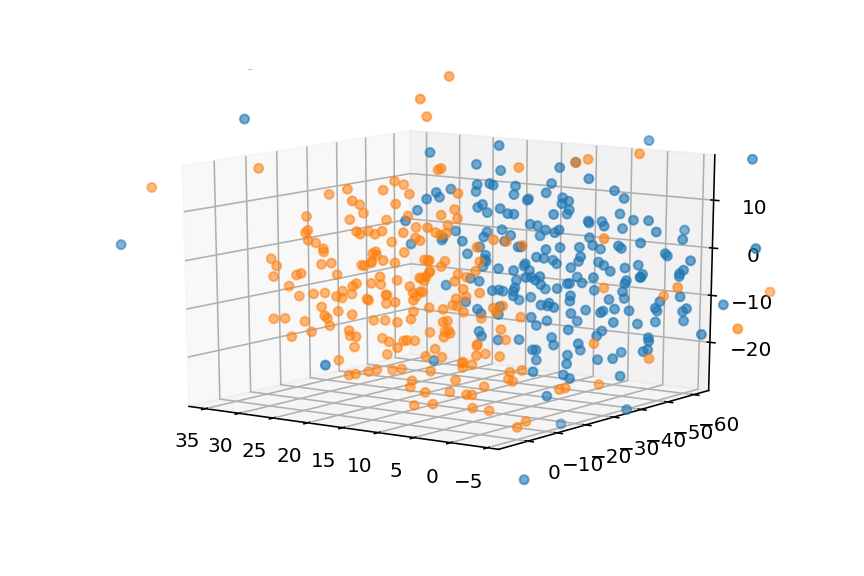

In [67]:
loadPlot(6)

<IPython.core.display.Javascript object>


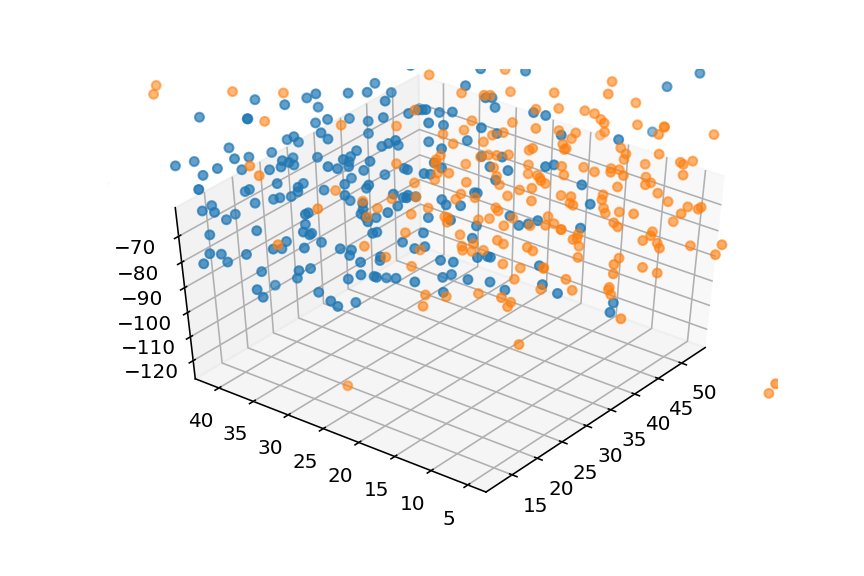

In [69]:
loadPlot(8)

<IPython.core.display.Javascript object>


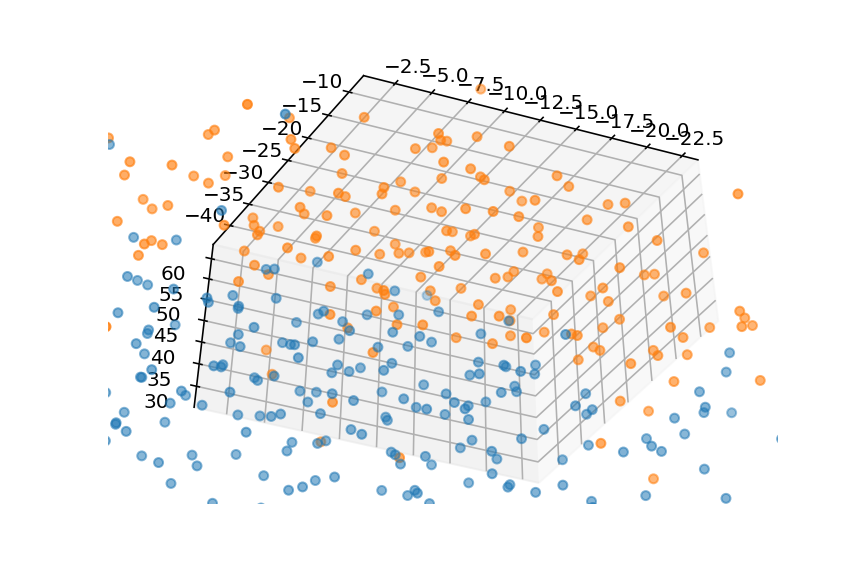

In [70]:
loadPlot(10)